In [1]:
%matplotlib notebook

import os
import time
import json
from glob import glob
from pprint import pprint
import random
import pickle

from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from collections import Counter
from nltk import FreqDist
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Get paths to extracted wiki dump

In [2]:
path = "./data/"
files = glob(path + "training_set*.json")
files.sort()
for f in files:
    print(f, os.stat(f).st_size )

./data/training_set.0.json 1487773630
./data/training_set.1.json 1487853209
./data/training_set.2.json 1488001701
./data/training_set.3.json 1489095692
./data/training_set.4.json 1484898178
./data/training_set.5.json 1483113488
./data/training_set.6.json 1485645495
./data/training_set.7.json 1484096922


In [3]:
with open(files[0], "r") as f:
    print(f.readline())

{"ans": "Anarchism", "text": "Anarchism Anarchism is a political philosophy that advocates self-governed societies based on voluntary institutions. These are often described as stateless societies, although several authors have defined them more specifically as institutions based on non-hierarchical or free associations. Anarchism holds the state to be undesirable, unnecessary and harmful."}



In [4]:
def data_generator(limit=None):
    for file in files[:limit]:
        with open(file, "r") as f:
            for line in f:
                 yield json.loads(line)

paras = [ii for ii in data_generator(1)]
pprint(paras[:2])
print(f"Total paragraphs in a single file: {len(paras)}")

[{'ans': 'Anarchism',
  'text': 'Anarchism Anarchism is a political philosophy that advocates '
          'self-governed societies based on voluntary institutions. These are '
          'often described as stateless societies, although several authors '
          'have defined them more specifically as institutions based on '
          'non-hierarchical or free associations. Anarchism holds the state to '
          'be undesirable, unnecessary and harmful.'},
 {'ans': 'Anarchism',
  'text': 'While opposition to the state is central, anarchism specifically '
          'entails opposing authority or hierarchical organisation in the '
          'conduct of all human relations. Anarchism is usually considered a '
          'far-left ideology and much of anarchist economics and anarchist '
          'legal philosophy reflects anti-authoritarian interpretations of '
          'communism, collectivism, syndicalism, mutualism or participatory '
          'economics.'}]
Total paragraphs in a si

# Create iterator to yield paragraphs

In [5]:
class WikidataIterator(object):
    def __init__(self, files, limit=None):
        self.files = files
        self.limit = limit
        self.i_to_ans = {}

    def _doc_iterator(self):
        counter = 0
        for path in self.files:
            with open(path, "r") as f:
                for line in f:
                    yield json.loads(line)
                    counter += 1
                    if self.limit and counter >= self.limit:
                        return

    @property
    def docs(self):
        counter = 0
        for doc in self._doc_iterator():
            ans = doc["ans"]
            text = doc["text"]

            self.i_to_ans[counter] = ans
            counter += 1
            yield text




Print a single paragraph to test

In [6]:
wikidata = WikidataIterator(files, limit=10)
docs = [item for item in wikidata.docs]
pprint(docs[0])
pprint(docs[1])
pprint(wikidata.i_to_ans)

('Anarchism Anarchism is a political philosophy that advocates self-governed '
 'societies based on voluntary institutions. These are often described as '
 'stateless societies, although several authors have defined them more '
 'specifically as institutions based on non-hierarchical or free associations. '
 'Anarchism holds the state to be undesirable, unnecessary and harmful.')
('While opposition to the state is central, anarchism specifically entails '
 'opposing authority or hierarchical organisation in the conduct of all human '
 'relations. Anarchism is usually considered a far-left ideology and much of '
 'anarchist economics and anarchist legal philosophy reflects '
 'anti-authoritarian interpretations of communism, collectivism, syndicalism, '
 'mutualism or participatory economics.')
{0: 'Anarchism',
 1: 'Anarchism',
 2: 'Anarchism',
 3: 'Anarchism',
 4: 'Anarchism',
 5: 'Anarchism',
 6: 'Anarchism',
 7: 'Anarchism',
 8: 'Anarchism',
 9: 'Anarchism'}


# Create TF/IDF Model

In [7]:
class TFIDF():

    def __init__(self, limit=None):
        self.i_to_ans = None
        self.limit = limit

    def train(self, ngram_range=(1, 1), min_df=2, max_df=.75):
        wikidata = WikidataIterator(files[:self.limit])
#         self.docs = [ii for ii in wikidata.docs]

        vectorizer_kwargs = {
            'ngram_range': ngram_range,
            'min_df': min_df,
            'max_df': max_df
        }
        start = time.time()
        self.tfidf_vectorizer = TfidfVectorizer(**vectorizer_kwargs).fit(wikidata.docs)
        elapsed = int(time.time() - start)
        print("INFO: fit completed in {} seconds".format(elapsed))

        start = time.time()
        self.tfidf_matrix = self.tfidf_vectorizer.transform(wikidata.docs)
        elapsed = int(time.time() - start)
        print("INFO: transform completed in {} seconds".format(elapsed))

        self.i_to_ans = wikidata.i_to_ans

    def guess(self, questions, max_n_guesses=2):
        representations = self.tfidf_vectorizer.transform(questions)
        guess_matrix = self.tfidf_matrix.dot(representations.T).T
        guess_indices = (-guess_matrix).toarray().argsort(axis=1)[:, 0:max_n_guesses]
        guesses = []
        for i in range(len(questions)):
            idxs = guess_indices[i]
            guesses.append([(self.i_to_ans[j], i, j, guess_matrix[i, j]) for j in idxs])

        return guesses

# Create test dataset loader

In [8]:
TEST_FILE = "./data/qanta.test.2018.04.18.json"

IGNORE_TEXT = [
    'for 10 points,',
    'For 10 points,',
    'for 10 points',
    'For ten points',
]

def load_data(filename):
    data = list()
    with open(filename) as json_data:
        for q in json.load(json_data)["questions"]:
            text = q['text']
            for ii in IGNORE_TEXT:
                text = text.replace(ii, "")
            yield  text, q['page']

def test_load():
    counter = 0
    for item in load_data(TEST_FILE):
        print(item)
        counter += 1
        if counter == 1: break
test_load()

('One work by this author uses printing, gunpowder, and the compass as symbols of personal ambition, national ambition, and the ambition of the human race to extend its grasp. This thinker described three forms of false learning as "delicate", "contentious", and "fantastical" in categorizing the "distempers" that impede academic progress. This thinker imagined a utopian university called Salomon\'s House, and he likened received systems of philosophy to stage plays that misrepresent the world, and thus labeled them "idols of the theatre". This author of The New Atlantis established the doctrine of inductive, empirical methodology.  name this 17th-century English philosopher who wrote Novum Organum and spearheaded the Scientific Revolution.', 'Francis_Bacon')


In [9]:
model = TFIDF()
model.train()

INFO: fit completed in 1558 seconds
INFO: transform completed in 1754 seconds


# Statistics on paragraphs

In [11]:
unique_answers = len(set(model.i_to_ans.values()))
print(f"unique answers: {unique_answers}")
print(f"total paragraphs: {len(model.i_to_ans)}")
print(f"average paras per page: {len(model.i_to_ans) / unique_answers}")

unique answers: 3354819
total paragraphs: 15922351
average paras per page: 4.746113277646275


count    3.354819e+06
mean     4.746113e+00
std      7.510228e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      4.890000e+02
dtype: float64


<IPython.core.display.Javascript object>


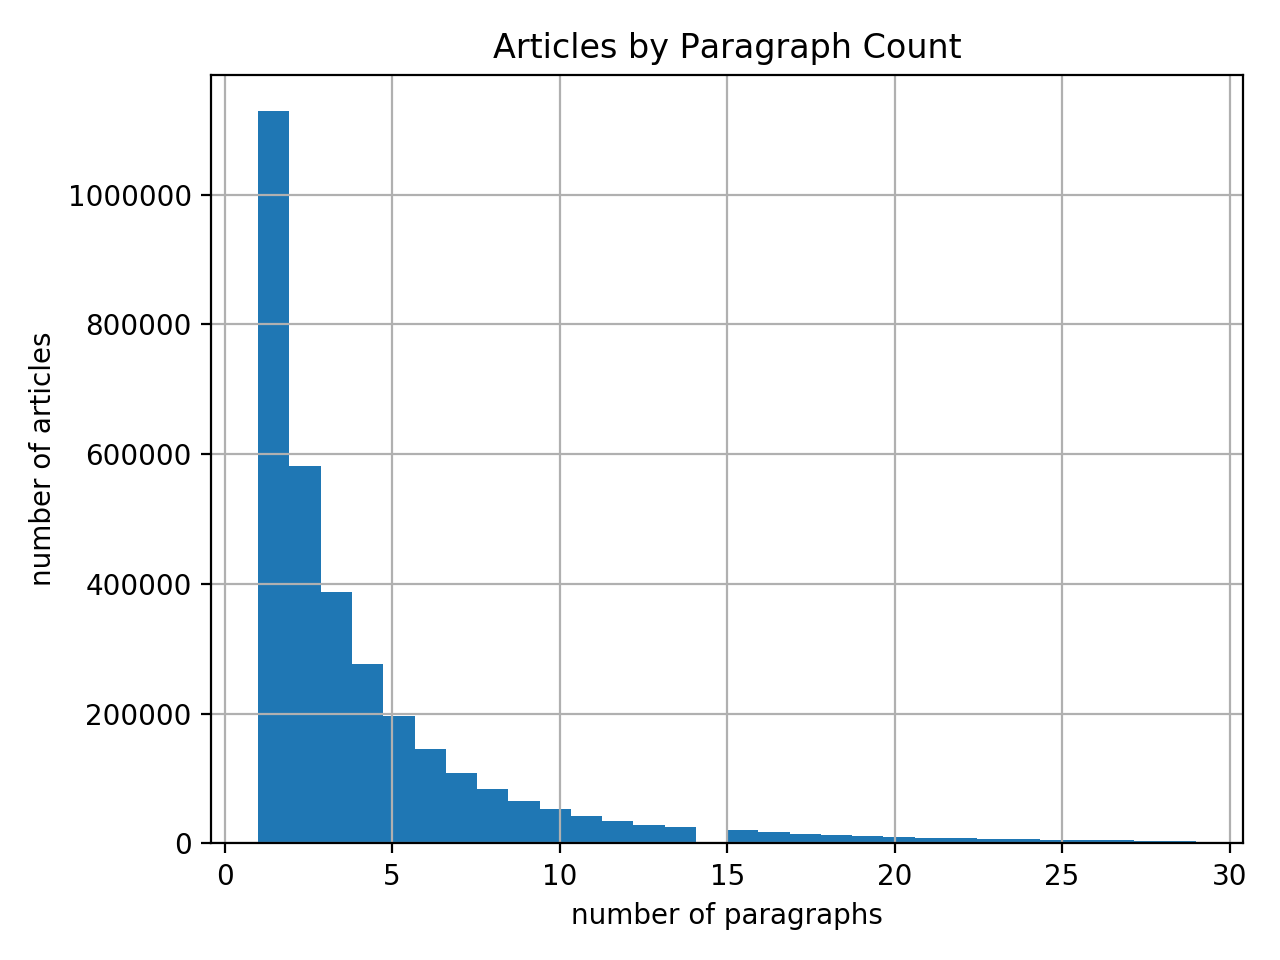

In [12]:
cc = Counter(list(model.i_to_ans.values()))
counts = pd.Series(list(cc.values()))
print(counts.describe())

fig, ax = plt.subplots()
ax.set_title("Articles by Paragraph Count")
ax.set_xlabel("number of paragraphs")
ax.set_ylabel("number of articles")
counts[counts < 30].hist(bins=30, ax=ax)
plt.tight_layout()

# Get Accuracy

In [14]:
NUM_TEST_QUESTIONS = 4104

def find_possible_answers():
    found = []
    known_answers = list(model.i_to_ans.values())
    
    for question, ans in tqdm_notebook(load_data(TEST_FILE),  total=NUM_TEST_QUESTIONS):
        if ans in known_answers:
            found.append(ans)
            
    return list(set(found))

test_answers_in_model = find_possible_answers()

In [15]:
print(test_answers_in_model[:20])
print("\nTest questions capable of being found by model: {}".format(len(test_answers_in_model)))

['Robert_Mapplethorpe', 'David_Lloyd_George', 'Sapa_Inca', 'Las_Vegas', 'Color_charge', 'Prophet', 'Millet', 'Context-sensitive_language', 'Maurice_Ravel', 'Jewish_quarter_(diaspora)', 'V._S._Naipaul', 'National_Action_Party_(Mexico)', 'Glycolysis', 'Mythology', 'New_Zealand', 'Unemployment', 'James_Hogg', '1905', 'The_Berkeley', 'Maya_Hero_Twins']

Test questions capable of being found by model: 3066


In [51]:
STOP_EARLY = 500

def get_accuracy():
    results = []
    counter = 0
    correct = 0
    idx = 0
    for question, ans in tqdm_notebook(load_data(TEST_FILE),  total=NUM_TEST_QUESTIONS):
        idx += 1
        data = {"index": idx, "question": question, "answer": ans, "guesses": [], "correct": None, "top3": None, "top5": None, }
        if ans in test_answers_in_model:
            counter += 1
            guesses = model.guess([question], max_n_guesses=5)[0]

            data["guesses"] = guesses
            labels = [ii[0] for ii in guesses]
            data["correct"] = ans == labels[0]
            data["top3"] = ans in labels[:3]
            data["top5"] = ans in labels[:5]
            
            if ans == labels[0]:
                correct += 1
                
            results.append(data)

        if counter == STOP_EARLY:
            break

        
    stats = {"correct": correct, "num_questions": counter, "accuracy": correct / counter if counter else 0,}  
    print(stats)
    return results, stats
        
start = time.time()
results, stats = get_accuracy()
print("elapsed: {}".format(time.time() - start))

{'correct': 21, 'num_questions': 500, 'accuracy': 0.042}
elapsed: 6069.511161804199


In [52]:
results[:3]

[{'index': 1,
  'question': 'One work by this author uses printing, gunpowder, and the compass as symbols of personal ambition, national ambition, and the ambition of the human race to extend its grasp. This thinker described three forms of false learning as "delicate", "contentious", and "fantastical" in categorizing the "distempers" that impede academic progress. This thinker imagined a utopian university called Salomon\'s House, and he likened received systems of philosophy to stage plays that misrepresent the world, and thus labeled them "idols of the theatre". This author of The New Atlantis established the doctrine of inductive, empirical methodology.  name this 17th-century English philosopher who wrote Novum Organum and spearheaded the Scientific Revolution.',
  'answer': 'Francis_Bacon',
  'guesses': [('Ambition_(charity)', 0, 3391444, 0.2730926856188344),
   ('London_Councils', 0, 12396884, 0.22826018732610098),
   ('Novum_Organum', 0, 14416449, 0.20983730573411857),
   ('Nov

# Add similar paragraphs to results and save for analysis

In [53]:
results2 = []

# convert numpy values to native Python types
for ii in results:
    item = ii.copy()
    guesses = []
    for guess in item["guesses"]:
        guess = list(guess)
        guess[2] = guess[2].item()
        guess[3] = guess[3].item()
        guesses.append(guess)
    item["guesses"] = guesses

    results2.append(item)

# reformat model guesses and include corresponding document/paragraph that it chose
for item in results2:
    guesses = item["guesses"]
    updated = []
    for g in guesses:
        data = {
            "answer": g[0],
            "para_number": g[2],
            "score": g[3],
            "para_text": model.docs[g[2]],
        }
        updated.append(data)
    item["guesses"] = updated

In [54]:
pprint(results2[0])

{'answer': 'Francis_Bacon',
 'correct': False,
 'guesses': [{'answer': 'Ambition_(charity)',
              'para_number': 3391444,
              'para_text': 'Ambition supports the annual PhoneBrain '
                           'competition, run by Ambition partner PhonepayPlus. '
                           'Leadership and Training Ambition’s Leadership '
                           'programme provides training for aspiring and '
                           'experienced young leaders. They support and '
                           'deliver courses that help young people gain '
                           'leadership qualifications. Ambition is part of a '
                           'consortium, led by Catch22, helping to run the '
                           'National Citizen Service (NCS). As part of the '
                           'consortium, Ambition has helped over 1,500 young '
                           'people complete their NCS. In October 2012, '
                           'Ambit

In [55]:
with open("results.json", "w") as f:
    f.write(json.dumps(results2))    


<br><br><br><br><br><br><br>
# Sanity Check

In [156]:
class WikidataIterator(object):
    def __init__(self, ignore=None):
        self.i_to_ans = {}
        self.data = [
            {"ans": "baseball", "text": "baseball glove catcher pitcher home run diamond base game"},
            {"ans": "tennis", "text": "racket serve volley ball court slam game match"},
            {"ans": "writing", "text": "pen paper typewriter novel write writing text copy fiction "},
        ]

    @property
    def docs(self):
        counter = 0
        for doc in self.data:
            ans = doc["ans"]
            text = doc["text"]

            self.i_to_ans[counter] = ans
            counter += 1
            yield text


toy = TFIDF()
toy.train(min_df=1)
print(toy.guess(["I brought my glove to the game as a child"]))
print(toy.guess(["I served the ball"]))


INFO: fit completed in 0 seconds
INFO: transform completed in 0 seconds
[[('baseball', 0, 0, 0.42894867283945587), ('tennis', 0, 1, 0.167236345046945)]]
[[('tennis', 0, 1, 0.3632547094545769), ('baseball', 0, 0, 0.0)]]
